In [1]:
!pip install tqdm

In [2]:
!pip install torchnet

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd drive/My Drive/

/content/drive/My Drive


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sn
import pandas as pd
import torchnet.meter.confusionmeter as cm

image_transformed_crops = 144
# Data augmentation and normalization for training
# Just normalization for validation & test
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(image_transformed_crops),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(image_transformed_crops),
        transforms.CenterCrop(image_transformed_crops),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'proper-set'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
classes = image_datasets['train'].classes


In [6]:
classes

['class-1', 'class-2', 'class-3', 'class-4', 'class-5']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


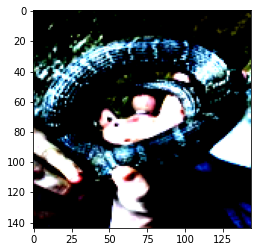

In [7]:
arr_ = image_datasets['train'][6][0].T
plt.imshow(arr_)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


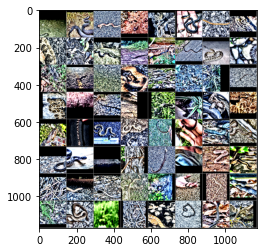

class-5 class-1 class-5 class-5


In [8]:
import numpy as np
import matplotlib.pyplot as plt
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# LilLuluNet



In [9]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class LilLuluNet(nn.Module):
    def __init__(self):
        super(LilLuluNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16* 33* 33, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16* 33* 33)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = LilLuluNet()
net.cuda()

print(device)

cuda:0


In [19]:
!nvidia-smi

Wed Mar 18 14:44:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    34W / 250W |   1019MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr = 0.001, betas=(0.9, 0.999))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) 

In [82]:
len(dataloaders['train'])

227

In [11]:
from tqdm import tqdm
epochs = 2
for epoch in range(epochs):  # loop over the dataset multiple times
    
    exp_lr_scheduler.step()

    running_corrects = 0 
    running_loss = 0.0
    indx = 0
    
    for data in tqdm(dataloaders['train'],position=0,leave=True):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)  

        # print statistics
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data) 

        epoch_loss = running_loss / dataset_sizes['train'] 
        epoch_acc = running_corrects.double() / dataset_sizes['train']
        
        if indx % 39 == 0:
          print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        indx += 1

print('Finished Training')

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  1%|▏         | 3/227 [00:01<03:43,  1.00it/s]

Loss: 0.0002 Acc: 0.0003


 17%|█▋        | 38/227 [00:12<01:05,  2.88it/s]

Loss: 0.0046 Acc: 0.0396


 35%|███▌      | 80/227 [00:23<00:34,  4.29it/s]

Loss: 0.0088 Acc: 0.0882


 52%|█████▏    | 118/227 [00:35<00:36,  2.96it/s]

Loss: 0.0130 Acc: 0.1410


 70%|███████   | 160/227 [00:46<00:16,  3.98it/s]

Loss: 0.0170 Acc: 0.1973


 86%|████████▋ | 196/227 [00:57<00:07,  3.88it/s]

Loss: 0.0211 Acc: 0.2537


  1%|▏         | 3/227 [00:01<03:38,  1.03it/s]

Loss: 0.0001 Acc: 0.0014


 17%|█▋        | 38/227 [00:12<01:13,  2.57it/s]

Loss: 0.0041 Acc: 0.0615


 34%|███▍      | 78/227 [00:23<00:54,  2.74it/s]

Loss: 0.0080 Acc: 0.1280


 52%|█████▏    | 119/227 [00:35<00:28,  3.75it/s]

Loss: 0.0120 Acc: 0.1888


 69%|██████▉   | 157/227 [00:46<00:21,  3.27it/s]

Loss: 0.0159 Acc: 0.2496


 87%|████████▋ | 197/227 [00:58<00:07,  3.79it/s]

Loss: 0.0199 Acc: 0.3084


100%|██████████| 2/2 [02:11<00:00, 65.83s/it]

Finished Training


# Run the code between this ONLY if you want to save and load the model

In [0]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(net, open(filename, 'wb'))

In [0]:
loaded_model = pickle.load(open(filename, 'rb'))

# Run the above code ONLY if you want to save and load the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


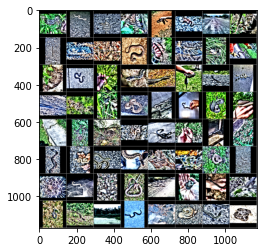

GroundTruth:  class-2 class-3 class-5 class-2


In [12]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
outputs = net(images.to(device))

In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  class-4 class-5 class-5 class-2


In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(dataloaders['test'],position=0,leave=True):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print()
print('Accuracy of the network on the all test images: %d %%' % (
    100 * correct / total))

100%|██████████| 96/96 [00:29<00:00,  3.26it/s]


Accuracy of the network on the all test images: 37 %


In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in tqdm(dataloaders['test'],position=0,leave=True):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print()
for i in range(5):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

100%|██████████| 96/96 [00:29<00:00,  3.27it/s]


Accuracy of class-1 : 51 %
Accuracy of class-2 :  4 %
Accuracy of class-3 : 34 %
Accuracy of class-4 : 15 %
Accuracy of class-5 : 80 %
